In [1]:
DATA_PATH = "./data/"
OUTPUT_PATH = "./out/"

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import lmfit
import sklearn

from sklearn.metrics import confusion_matrix

colorDic = {"blue" : "#6599FF", "yellow" : "#FFAD33",  "purple": "#683b96", "green" : "#198D6D", "red" : "#FF523F"}
colors = list(colorDic.values())

In [5]:
dfStim = pd.read_pickle(DATA_PATH  + "data_02_stim.pkl")
dfAcc = pd.read_pickle(DATA_PATH  + "data_01_acc.pkl")

In [6]:
lstS = []
lstJ = []
for s in dfAcc.Speed.unique():
    arr = dfAcc[dfAcc.Speed == s].Acc.values
    arr2 = np.zeros(len(arr))
    arr2[1:] = np.diff(arr)
    arrSpeed = np.zeros(len(arr))
    arrSpeed[:] =  dfAcc[dfAcc.Speed == s].index
    lstS.append(arrSpeed)
    lstJ.append(arr2)
dfX = pd.DataFrame(np.array([np.concatenate(lstS),np.concatenate(lstJ)]).T, columns=["I", "Jerk"])
dfAcc["Jerk"] = dfX.set_index("I").Jerk

In [7]:
minval = -200
maxval = 6000
binwidth = 50
dfStim["Bin"] = np.digitize(dfStim.TimeRelativ, list(range (minval,maxval,binwidth)))

In [8]:
df2 = dfStim[(dfStim.SpeedCondition == s) & (dfStim.IsBumpVirtual == 1.0) & (dfStim.TouchType == 2)]
df2.TouchOffset.describe()

count     821.000000
mean       61.846836
std        90.545938
min         0.633333
25%        24.331872
50%        45.775588
75%        73.771780
max      1098.334402
Name: TouchOffset, dtype: float64

In [9]:
df2 = dfStim[(dfStim.SpeedCondition == s) & (dfStim.IsBumpVirtual == 1.0) & (dfStim.TouchType == 2)]
df3 = df2.groupby("Bin")[["TouchOffset", "TouchOffsetX", "TouchOffsetY"]].mean()
df3.head()

,TouchOffset,TouchOffsetX,TouchOffsetY
Bin,,,
2,379.949530,-50.033333,325.850000
4,380.999879,-98.800000,367.966667
5,65.045239,2.026667,3.995758
6,63.646588,0.890090,-44.222072
7,89.431474,5.260185,-16.132407


In [10]:
TouchEventId = dfStim.groupby(["TouchId"])["TouchEventId"].max().values

In [11]:
def fun(params, x):
    x0 = np.zeros(len(params))
    for i in range(len(params)):
        x0[i] = params["x"+str(i)]
    s = int(np.sqrt(len(params)))
    return np.polynomial.polynomial.polyval(x, x0)

def residual(params, x, z):
    x0 = np.zeros(len(params))
    for i in range(len(params)):
        x0[i] = params["x"+str(i)]
    s = int(np.sqrt(len(params)))
    return np.polynomial.polynomial.polyval(x, x0) - y

In [12]:
def fit (X, Error, noCI = False):
    params = lmfit.Parameters()
    for i in range(11):
        params.add('x%i'%i, value=0)
    
    minfit = lmfit.Minimizer(residual, params, fcn_args=(X, Error))
    # first solve with Nelder-Mead
    out1 = minfit.minimize(method='Nelder')

    # then solve with Levenberg-Marquardt using the
    # Nelder-Mead solution as a starting point
    out2 = minfit.minimize(method='leastsq',  params=out1.params)

    if (noCI == False):
        ci, trace = lmfit.conf_interval(minfit, out2, sigmas=[2],
                                        trace=True, verbose=False)
        lst = []
        for name, row in ci.items():
            for cval, val in row:
                if (ci["a"][0][0] == cval):
                    lst.append([name, val])
        lst

        dfCoff = pd.DataFrame(lst, columns=["Coff", "Val"])
        dfCoff = dfCoff.groupby("Coff").agg({"Val": [np.min, np.max]})
        dfCoff.columns = ["Min", "Max"]
        dfCoff =dfCoff.reset_index()
        dfX = pd.DataFrame.from_dict(out2.params.valuesdict(), orient="index")
        dfX = dfX.reset_index()
        dfX.columns =["Coff", "Val"]
        dfCoff = pd.merge(dfCoff, dfX, on="Coff")
        return out2, dfCoff
    else:
        return out2

Speed 10
    R²                 = 0.460993
Speed 20
    R²                 = 0.449793
Speed 30
    R²                 = 0.792288
Speed 40
    R²                 = 0.742326
Speed 50
    R²                 = 0.846673


[Text(0,0,'0.0'),
 Text(0,0,'0.5'),
 Text(0,0,'1.0'),
 Text(0,0,'1.5'),
 Text(0,0,'2.0'),
 Text(0,0,'2.5')]

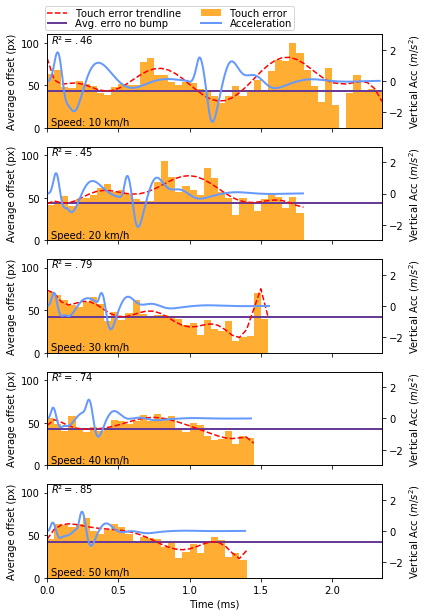

In [13]:
fig, axarr = plt.subplots(5, 1, sharex=True, figsize=(6,10))
plt.xlabel("Time (ms)")

meanNoBump = dfStim[(dfStim.IsBumpVirtual == 0) & dfStim.TouchEventId.isin(TouchEventId) & (dfStim.TouchType == 2)].groupby("SpeedCondition").mean().TouchOffset

for i in range(5):
    s = ((i+1) *10)
    ax = axarr[i]
    #fig, ax = plt.subplots(figsize=(6,2))
    #ax.set_title()
    ax.annotate("Speed: %i km/h" % (10*(i+1)) ,(30,3))
    df2 = dfStim[(dfStim.SpeedCondition == s) & (dfStim.TouchEventId.isin(TouchEventId)) & (dfStim.IsBumpVirtual == 1.0) & (dfStim.TouchType == 2)]
    #print(df2.TouchOffset.describe())
    df3 = df2.groupby("Bin").mean()
    r = (minval,maxval)
    plt.bar
    l1 = ax.bar((df3.index*binwidth)+r[0]-(binwidth/2.0), df3.TouchOffset, width=binwidth, color=colorDic["yellow"], label='Touch error')
    
    df2 = df2.copy()
    df2["TimeBin"] = np.round((df2.TimeRelativ/50).astype(float))*50
    df3 = df2.sort_values("TimeRelativ").groupby("TimeBin").mean().TouchOffset
    x = df3.index
    y = df3.values
    out1 = fit(x,y, noCI=True)
    print("Speed %i" % (s))
    rsquared = sklearn.metrics.r2_score(y, fun(out1.params, x))
    print ("    R²                 = %.6f" % rsquared)
    ax.plot(x, fun(out1.params, x),"r--", label="Touch error trendline")
    rs = ("$R²= %.2f$" % (rsquared)).replace("0.", ".")
    ax.annotate(rs,(30,100))
    
    ax.hlines(meanNoBump[int((i+1)*10)], 0, 2500, color=colorDic["purple"], lw=2, label="Avg. erro no bump")

    ax2 = ax.twinx()
    df = dfAcc[dfAcc.Speed == s]
    l2=ax2.plot(df.Time, (df.Acc), label="Acceleration", c=colorDic["blue"], lw=2)
    
    ax.set_ylabel("Average offset (px)")
    ax2.set_ylabel("Vertical Acc ($m/s^2$)")
    
    ax.set_ylim((0,110))    
    ax2.set_ylim(-3,3)
    
    if (i== 0):
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, ncol=2, loc=2, borderpad = 0.2, labelspacing = 0, bbox_to_anchor=(-.02, 1.25, 1., .10)) 

plt.xlim((0,2350))
ax.set_xticklabels(ax.get_xticks() /1000)
#plt.savefig(OUTPUT_PATH + "offset.pdf", bbox_inches='tight',transparent=False, pad_inches=0)
#plt.show()

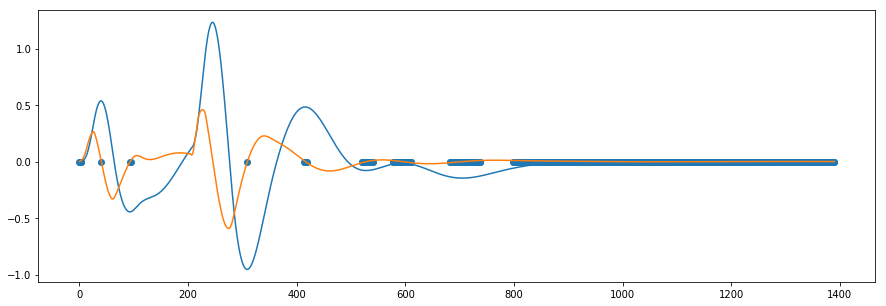

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(arr)
plt.plot(arr2*10)
#pos = np.where((arr > 0.03))[0]
#plt.scatter(pos, np.ones(len(pos)))
pos = np.where((arr2 < 0.001) & (arr2 > -0.001))[0]
plt.scatter(pos, np.zeros(len(pos)))

In [15]:
dfX =dfAcc[["Time", "Speed", "Acc", "Jerk"]]

In [16]:
dfMerge = pd.merge(dfStim, dfX, left_on=["SpeedCondition", "TimeRelativ"], right_on=["Speed", "Time"], how="left")
dfMerge.loc[dfMerge.Time.isna(), "Acc"] = 0.0
dfMerge.loc[dfMerge.Time.isna(), "Jerk"] = 0.0
del dfMerge["Time"]
del dfMerge["Speed"]

In [17]:
dfMerge.TimeRelativ = dfMerge.TimeRelativ.astype(int)
dfMerge.SpeedCondition = dfMerge.SpeedCondition.astype(int)
             

# Calc time to last peak

In [18]:
arr2 = dfAcc[dfAcc.Speed == 10].Jerk

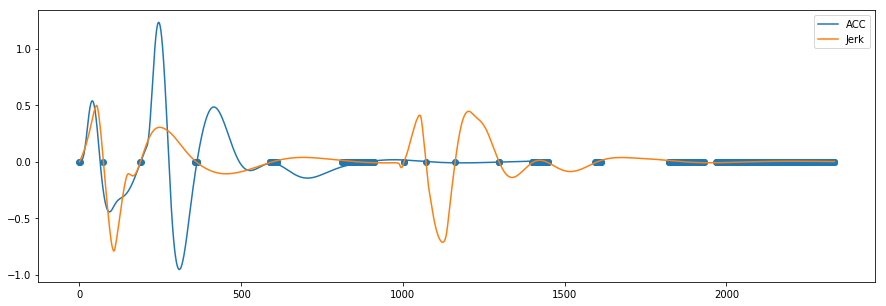

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(arr, label="ACC")
plt.plot(arr2*10)
#pos = np.where((arr > 0.03))[0]
#plt.scatter(pos, np.ones(len(pos)))
pos = np.where((arr2 < 0.001) & (arr2 > -0.001))[0]
plt.scatter(pos, np.zeros(len(pos)))
plt.legend()

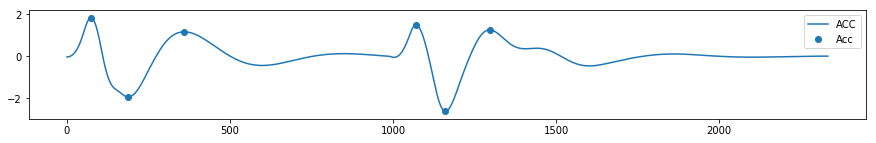

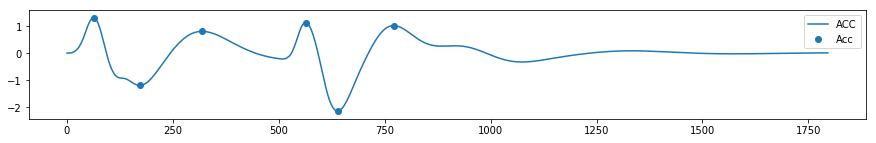

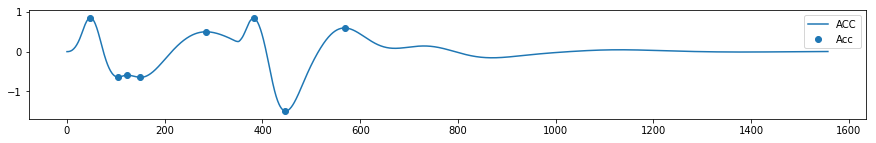

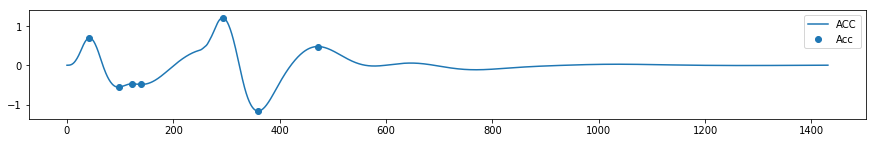

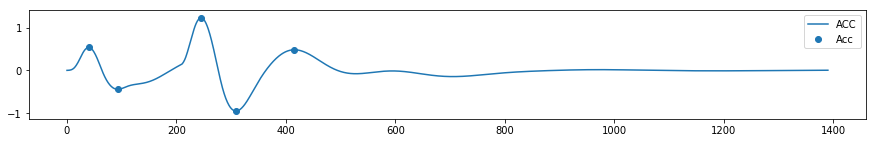

In [22]:
dic = {}
for s in dfAcc.Speed.unique():
    a = dfAcc[dfAcc.Speed == s].Acc.values
    a = (a/(a.max()-a.min()))
    posMin = np.where((np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True]) == True)[0][1:]
    posMax = np.where((np.r_[True, a[1:] > a[:-1]] & np.r_[a[:-1] > a[1:], True]) == True)[0][:]
    pos = np.concatenate([posMin, posMax])
    pos= pos[np.where((a[pos] > 0.2) | (a[pos] < -0.2) )]
    plt.figure(figsize=(15, 2))
    dic[s] = np.array(sorted(dfAcc[dfAcc.Speed == s].iloc[pos].Time.values))
    plt.plot(dfAcc[dfAcc.Speed == s].Time, dfAcc[dfAcc.Speed == s].Acc, label="ACC")
    #pos = np.where((arr > 0.03))[0]
    #plt.scatter(pos, np.ones(len(pos)))
    plt.scatter(dfAcc[dfAcc.Speed == s].iloc[pos].Time, dfAcc[dfAcc.Speed == s].iloc[pos].Acc)
    plt.legend()

In [23]:
dic

{10: array([  74,  188,  360, 1071, 1161, 1296]),
 20: array([ 63, 172, 319, 563, 639, 771]),
 30: array([ 48, 105, 123, 150, 285, 382, 447, 568]),
 40: array([ 42,  97, 123, 140, 293, 360, 472]),
 50: array([ 40,  93, 245, 309, 415])}

In [24]:
%%time
lst  =[]
for i, e in dfMerge.iterrows():
    peaks = dic[e.SpeedCondition]
    if (len(np.where(peaks < e.TimeRelativ)[0]) > 0):
        lst.append(peaks[np.where(peaks < e.TimeRelativ)[0].max()])
    else:
        lst.append(-1)
    #for peaks in 

CPU times: user 8.47 s, sys: 87.7 ms, total: 8.56 s
Wall time: 8.48 s


In [25]:
dfMerge["TimePeak"] = lst

In [27]:
dfMerge.head()

,SpeedCondition,TimeOfBump,TimeOfVisual,VisualStimuliCondition,VisualStimuliPosition,VisualStimuliPositionX,VisualStimuliPositionY,IsBump,TimeOfTouch,TouchX,...,AccDiff,VisualStimuliId,IsBumpVirtual,TouchEventId,TouchOffsetX,TouchOffsetY,Bin,Acc,Jerk,TimePeak
0,10,15000,15150,3.0,"(738, 50)",1402.2,95.0,1.0,16164,1362.933333,...,-0.010707,0,1.0,0,-39.266667,-6.333333,13,0.587547,-0.010707,360
1,10,15000,15150,3.0,"(738, 50)",1402.2,95.0,1.0,16180,1362.933333,...,-0.010756,0,1.0,1,-39.266667,-6.333333,14,0.415103,-0.010756,360
2,10,15000,15150,3.0,"(738, 50)",1402.2,95.0,1.0,16215,1362.933333,...,-0.009304,0,1.0,2,-39.266667,-6.333333,14,0.059490,-0.009304,360
3,10,15000,15150,3.0,"(738, 50)",1402.2,95.0,1.0,16245,1364.200000,...,-0.006941,0,1.0,3,-38.000000,-6.333333,15,-0.184827,-0.006941,360
4,10,15000,15150,3.0,"(738, 50)",1402.2,95.0,1.0,16274,1371.800000,...,-0.004186,0,1.0,4,-30.400000,-11.400000,16,-0.345365,-0.004186,360


In [ ]:
%%time
x = dfMerge.apply(lambda x: dfAcc[(dfAcc.Speed == x["SpeedCondition"]) & (dfAcc.Time == x["TimePeak"])].Acc.values[0] if len(dfAcc[(dfAcc.Speed == x["SpeedCondition"]) & (dfAcc.Time == x["TimePeak"])].Acc.values) > 0 else -1, axis=1)

In [ ]:
dfMerge["PeakValue"] = x

In [ ]:
dfMerge.to_pickle(DATA_PATH  + "data_03_stim.pkl")